* NAME: RISHABH PATIL
* SAP: 60009200056
* BATCH: K2

In [5]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [18]:
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

In [10]:
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
def play_episode(env):
    """
    Plays a single episode with a set policy in the environment given. Records the state, action 
    and reward for each step and returns the all timesteps for the episode.
    """
    episode = []
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [6]:
def update_Q(episode, Q,returns_sum, N, gamma=1.0):
    """
    For each time step in the episode we carry out the first visit monte carlo method, checking if this is 
    the first index of this state. Get the discounted reward and add it to the total reward for that 
    state/action pair. Increment the times we have seen this state action pair and finally update the Q values
    """
    
    for s, a, r in episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[s][a] += G
            N[s][a] += 1.0
            Q[s][a] = returns_sum[s][a] / N[s][a]

In [7]:
def mc_predict(env, num_episodes, gamma=1.0):

    """
    This is the primary method. Plays through several episodes of the environment. 
    """
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        episode = play_episode(env)

        update_Q(episode, Q, returns_sum, N)
            
    return Q 

In [12]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    
    X, Y = np.meshgrid(player_sum, dealer_show)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')

In [ ]:
#predict the policy values for our test policy
Q = mc_predict(env, 500000)

#get the state value function for our test policy
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())


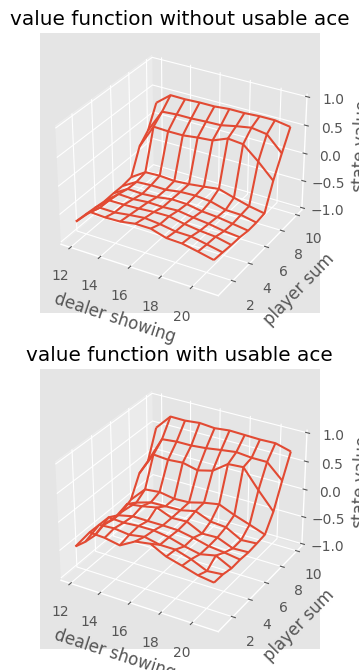

In [21]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(V_to_plot,axes[0], axes[1])